/var/folders/mb/t0rlzzmd4mv1nlj693qygfmh0000gn/T/ipykernel_64952/2698967363.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'male':1,'female':0}, inplace=True)


,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN


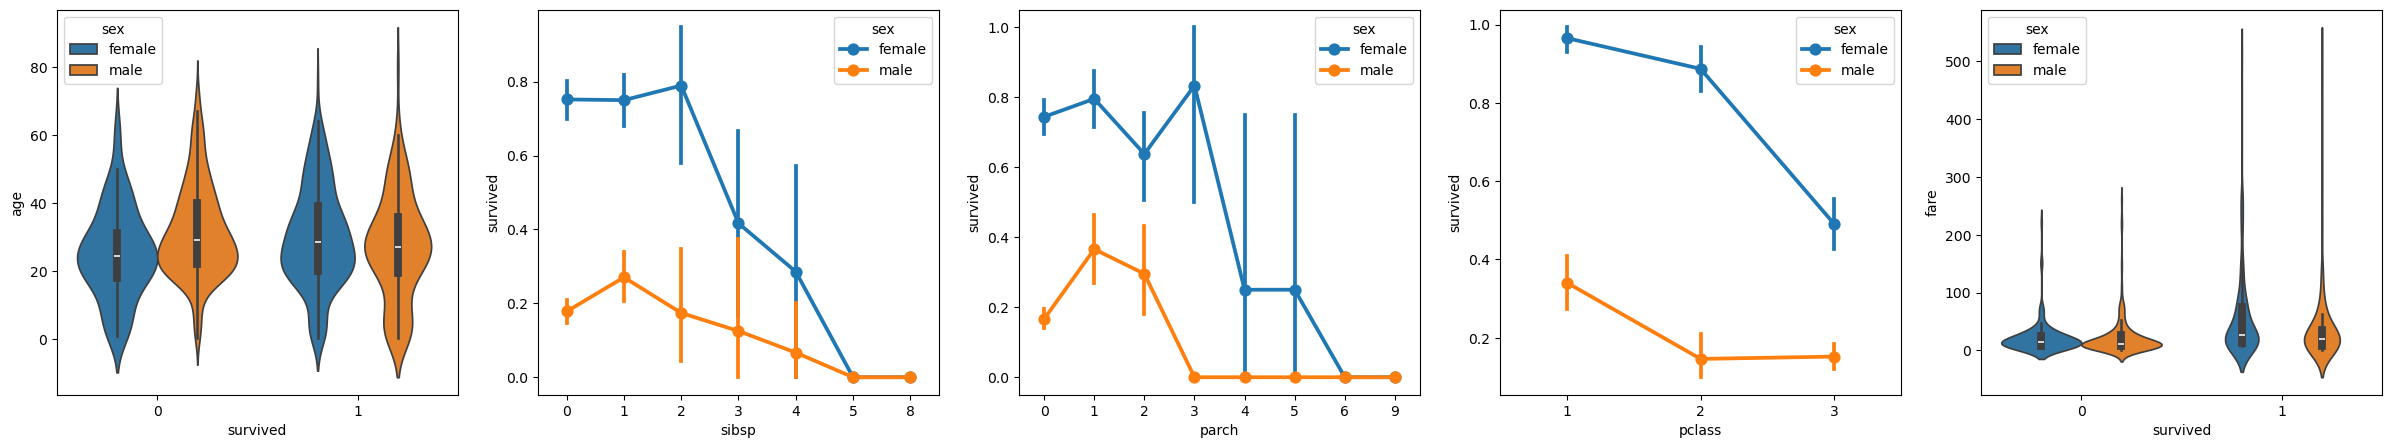

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('titanic3.csv')


#To make graphs, replacing the question mark with a missing value that pandas is able to understand. 
#Replace the question marks in the age and fare columns with the numpy NaN value. 

## np.nan: Special floating-point value indicating a missing number.
## inplace=True: Modifies the DataFrame directly instead of creating a new copy.

data.replace('?', np.nan, inplace=True)


# update the column's data type after replacing question marks with NaN == Ensures that the age and fare columns are of type float64 (64-bit floating-point numbers).
# the columns might still be interpreted as strings. This line ensures they are correctly treated as numerical data.
data = data.astype({"age": np.float64, "fare": np.float64})

import seaborn as sns 
import matplotlib.pyplot as plt

#Setting image save file path 
filepath = "/Users/celine/my_project/Titanic Survival Correlation Prediction/images"
def get_next_filename (filepath, base_name="image", ext="svg"):
    num = 1 
    while os.path.exists(f"{filepath}/{base_name}_{num}.{ext}"):
        num += 1
    return f"{filepath}/{base_name}_{num}.{ext}"

def save_files (data, filepath, base_name="results", extensions=None):
    if extensions is None: 
        extensions = ["csv"]

    saved_files = {}
    for ext in extensions:
        filename = get_next_filename (filepath, base_name, ext)
        saved_files[ext] = filename 
        
        if isinstance (data, pd.DataFrame) and ext == "csv":
                data.to_csv(filename, index=False)
            
        elif isinstance(data, plt.Figure):
            data.savefig(filename, format=ext)
        
        print(f"Saved {ext.upper()} as: {filename}")
    return saved_files
    

## figsize=(30,5): Sets the figure size to 30 units wide and 5 units high.
fig,axs = plt.subplots(ncols=5, figsize=(30,5))

## hue="sex": Differentiates the data by sex.
## Violin Plot: Combines boxplot and density plot to show the distribution of age for survivors and non-survivors, categorised by sex.
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
plt.save_files(filename, format='svg')

## Point Plot: Displays the mean survival rate for each sibling/spouse count (sibsp), categorised by sex. --> To see if having more siblings/spouses on board affected survival.
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
plt.savefig(filename, format='svg')

## Point Plot: Shows the average survival rate for different numbers of parents/children (parch) aboard, categorised by sex. --> Why: To understand how family size influenced survival.
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
plt.savefig(filename, format='svg')

## Point Plot: Illustrates the relationship between passenger class (pclass) and survival, with data separated by sex.--> Why: To analyse the survival disparity between classes.
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
plt.savefig(filename, format='svg')

## 	Violin Plot: Shows fare distribution for survivors and non-survivors, split by sex. -->	Why: To explore whether higher fares correlated with higher survival rates.
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])
plt.savefig(filename, format='svg')

# Calculate correlation(survival, input variables) via Pandas
# Encoding Categorical Data == Convert string values to numeric integers (ML requires numerical input)
data.replace({'male':1,'female':0}, inplace=True)
save_files(df, filepath)

#Analyze the correlation between all the input variables to idnetify the features that would be the best inputs to a ML model.
## numeric_only=True: Ensures only numeric columns are included in the correlation calculation.
## abs(): Returns the absolute values of correlations, so both positive and negative correlations are treated equally.
## .corr() method calculates the Pearson correlation coefficient between variables, which can range from -1 to 1:
### 1: Perfect positive correlation, 	-1: Perfect negative correlation, 0: No correlation
### When analysing correlations, we often care about the strength rather than the direction (positive or negative).
### 	.abs() converts all correlation values to positive to simplify comparison, allowing us to quickly see the strongest correlations.

data.corr(numeric_only=True).abs()[["survived"]]

# if written "data.corr(numeric_only=True).abs()["survived"]" --> return a Series rather than a DataFrame.
# double brackets, we are explicitly asking for a subset of the DataFrame, preserving the 2D structure.


In [ ]:

# The hypothesis here is that having relatives on board could significantly affect survival chances
# == whether sibsp and parch (sibsp = siblings or spouse, parch = parents or children) are related in how they affect survivability,


# To do so, check if for a given passenger, #(sibsp + parch)> 0 and, if so, they had a relative on board.


# Instead of analysing sibsp (siblings/spouse) and parch (parents/children) separately, they are combined into a new column called “relatives”.
# sibsp (siblings/spouse) and parch (parents/children) are treated as indicators of whether the passenger had family on board.


# if the created "relatives" column indicates whether a passenger had at least one relative on board,
#  they are grouped into a new column called "relatives" to see whether the combination of them has a higher correlation to survivability. 


## apply(): to iterate through each row of the DataFrame.
## Lambda function: Takes a row as input, checks if the sum of sibsp and parch is greater than 0.
###	If yes, it returns 1 (indicating at least one relative); otherwise, it returns 0.
#### Lambda x: x*2 means, "take x and return x*2" --> Hence, below, 내가 봤을 때는 "take row and if int((row['sibsp'] + row['parch']) > 0, axis=1"
## axis=1: Specifies that the function is applied to rows (not columns).

data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)

# Calculates the correlation between “survived” and other numerical features.--> o see if the newly created “relatives” column has a higher correlation with survival than the original sibsp and parch columns.
data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN
relatives,0.201719


In [73]:
# notice that in fact when looked at from the standpoint of whether a person had relatives, versus how many relatives, there is a higher correlation with survival.
# Drop from the dataset the low value sibsp and parch columns, as well as any rows that had NaN values, 
# Why? to end up with a dataset that can be used for training a model.
## Simplifying the dataset improves model efficiency and accuracy.

#Although age had a low direct correlation, it was kept because it seems reasonable that it might still have correlation in conjunction with other inputs.


data = data[['sex', 'pclass', 'age','relatives','fare','survived']].dropna()


[Train and evaluate Model]

With the dataset ready, begin creating a model. For this section, use the scikit-learn library as it offers some useful helper functions. 

To do pre-processing of the dataset:
1. train a classification model to determine survivability on the Titanic, and 
2. Then use that model with test data to determine its accuracy.

A common first step to training a model is to divide up the dataset into training and validation data. 

This allows you to use a portion of the data to train the model and a portion of the data to test the model. 


If you used all your data to train the model, you wouldn't have a way to estimate how well it would actually perform against data the model hasn't yet seen. A benefit of the scikit-learn library is that it provides a method specifically for splitting a dataset into training and test data.

In [74]:
# divide up the dataset into training and validation data. 
## train_test_split(): Splits data into training (80%) and testing (20%) sets.
## test_size=0.2: Reserves 20% for testing.
## random_state=0: Ensures reproducibility by setting a random seed.
## x_train, x_test: Feature sets for training and testing.
## y_train, y_test: Target labels for training and testing.



from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass', 'age', 'relatives', 'fare']], data.survived, test_size=0.2, random_state=0)

Scale the input values == Normalize the inputs such that all features are treated equally. For example, within the dataset the values for age range from ~0-100, while gender is only a 1 or 0. 

By normalizing all the variables, you can ensure that the ranges of values are all the same. 

In [75]:
# Scale the input values == Normalize the inputs such that all features are treated equally.
# Ensures that all features have a mean of 0 and a standard deviation of 1.
## fit_transform(): Fits the scaler on the training data and transforms it.
## transform(): Applies the same scaling to the test data (using the scaling factors learned from the training data).

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

There are many different <machine learning algorithms> that you could choose from to model the data. The scikit-learn library also provides support for many of them and a chart to help select the one that's right for your scenario. For now, use the <Naïve Bayes algorithm>, a common algorithm for classification problems. Add a cell with the following code to create and train the algorithm.

In [76]:
#To model the data, use the Naïve Bayes algorithm>, a common algorithm for classification problems
# <Nive Bayes algorithm> is:
##  suitable fo  binary classification tasks, 
## Efficient for continuous data (GaussianNB handles continuous features).
## Assumes features are conditionally independent given the class, which works well for simpler problems.

## 	fit(): Trains the model using the training data.

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

# Evaluate the model's performance: Test the data set that was held back from training
# == Predict the outcome of the test data and calculate the accuracy of the model.
## model.predict(): Uses the trained model to predict survival on the test set.
## metrics.accuracy_score(): Compares the predicted values with the actual y_test values to calculate accuracy.


from sklearn import metrics
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885


In [77]:
[Use a Neural Network]

NN uses weights and activation functions, modeling aspects of human neurons, to determine an outcome based on provided inputs. 

Unlike the ML algorithm you looked at previously, neural networks are a form of deep learning wherein you don't need to know an ideal algorithm for your problem set ahead of time. 

NN can be used for many different scenarios and classification is one of them. For this section, you'll use the <Keras library> with <TensorFlow> to construct the neural network, and explore how it handles the Titanic dataset.

--

* The <rectified linear unit (relu) activation function> is used as a good general activation function for the first two layers, while the <sigmoid activation function> is required for the final layer as the output you want (of whether a passenger survives or not) needs to be scaled in the range of 0-1 (the probability of a passenger surviving).


SyntaxError: unterminated string literal (detected at line 5) (1901081364.py, line 5)

In [ ]:
# Define NN Model
# Sequential NN is a layered neural network wherein there are multiple layers that feed into each other in sequence.
## Sequential: Used to build models layer by layer --> why? Simple structure where layers are stacked in sequence. Ideal for straightforward feedforward networks.

# Keras: A high-level neural networks API, part of TensorFlow.
# Dense: A fully connected layer where each neuron from one layer connects to every neuron in the next layer.


from keras.models import Sequential 
from keras.layers import Dense

# Creates an empty neural network model. 
## Why: You start with an empty Sequential model to which layers are added one by one.

model = Sequential() 





# Add the NN layers. For now, just use three layers.
## Set first layer to have a dimension of 5 since we have five inputs: sex, pclass, age, relatives, and fare.
### input_dim=5: Specifies the number of input features (sex, pclass, age, relatives, fare).

## Activation Function (ReLU):
### ReLU (Rectified Linear Unit): max(0, x), efficient for most neural network tasks. Helps mitigate the vanishing gradient problem by allowing positive values to pass through.
## Kernel Initialiser (Uniform):Randomly initialises the weights in a uniform distribution.nsures that initial weights are not too small or too large.


model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5))

## Set middle layer at 5 for simplicity. The value can be different. 
## This is a HIDDEN Layer with 5 neurons and ReLU activation
### Why ReLU Again: Keeps non-linearity and prevents vanishing gradients.
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))

## Set the last layer at 1 because we want 1-dimensional output indicating whether a passenger would survive. 
## == Scale in the range of 0-1 (the probability of a passenger surviving
###  Dense(1): Only 1 neuron because the output is binary (survived or not).
### Activation Function (Sigmoid): 
#### Produces output in the range [0, 1], interpreted as the probability of survival.
#### Ideal for binary classification tasks.
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# View the summary of the model
model.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Once the model is created, it needs to be compiled. This step may take anywhere from a few seconds to a few minutes to run depending on your machine.

In [ ]:
# Choose the type of otimiser (how loss will be calculated, wht metric should be optimised)
# Build & train the model 


# <Build> 
# Optimizer (Adam): Combines the advantages of AdaGrad and RMSProp. Efficient for large data and high-dimensional parameter spaces.
# Loss Binary Crossentropy):
## Suitable for binary classification.
## Measures the difference between the actual and predicted probabilities.
# Metrics (Accuracy):	Used to evaluate model performance. Outputs the percentage of correctly predicted labels.
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


# <Train>
# Batch Size (32): Number of samples processed before updating the model.
## Smaller batches make the model more responsive to changes in the data.

# Epochs (50): Number of complete passes through the training dataset.
## More epochs help the model learn better but can lead to overfitting.

# Why fit(): Fits the model on the training data.
model.fit(X_train, y_train, batch_size=32, epochs=50)

# see how the built & trained model works aginst the test data
# The result yields 79%. Using this simple neural network, the result is better than the 75% accuracy from the Naive Bayes Classifier tried previously.
## model.predict(X_test): Predicts the probability of survival for each test sample.
## flatten(): Converts the output array to a 1D array.
## np.rint(): Rounds the predicted probability to the nearest integer (0 or 1), as the output from the sigmoid function can be any value between 0 and 1.

y_pred = np.rint(model.predict(X_test).flatten())
print(metrics.accuracy_score(y_test, y_pred))

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.5972 - loss: 0.6926
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6047 - loss: 0.6902
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.5926 - loss: 0.6874
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5638 - loss: 0.6835
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5833 - loss: 0.6737
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.6124 - loss: 0.6555
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.6604 - loss: 0.6412
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7451 - loss: 0.6220
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7629 - loss: 0.6038
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.7843 - loss: 0.5620
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.7669 - loss: 0.5628
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step